---
title: Generate Virtual Zarr from CMIP6 NetCDF files
description: Tutorial for data providers who want to create a virtual icechunk store for NetCDF files.
author: Aimee Barciauskas, Julia Signell
date: September 16, 2025
execute:
  freeze: true
  cache: true
---

## Run this notebook

You can launch this notebook in VEDA JupyterHub by clicking the link below.

[Launch in VEDA JupyterHub (requires access)](https://hub.openveda.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/user-guide/notebooks/veda-operations/generate-cmip6-virtual-zarr-historical.ipynb&branch=main) 

<details><summary>Learn more</summary>
    
### Inside the Hub

This notebook was written on a VEDA JupyterHub instance

See (VEDA Analytics JupyterHub Access)[https://nasa-impact.github.io/veda-docs/veda-jh-access.html] for information about how to gain access.

### Outside the Hub

You are welcome to run this anywhere you like (Note: alternatively you can run this on https://daskhub.veda.smce.nasa.gov/, MAAP, locally, ...), just make sure that the data is accessible, or get in contact with the VEDA team to enable access.

</details>

## Approach

This notebook demonstrates how to create a [virtual Icechunk store](https://icechunk.io/en/latest/virtual/) reference for the [AWS Open Data Registry of NASA Earth Exchange Global Daily Downscaled Projections (NEX-GDDP-CMIP6)](https://registry.opendata.aws/nex-gddp-cmip6/) NetCDF files on S3. Because the NetCDF files are publicly avaialble, this notebook should be runnable in any environment with the imported libraries, up until the last step where the Icechunk store is stored in the veda-data-store-staging S3 bucket, as that is a protected bucket.

To see how to publish a virtual Icechunk store to a STAC collection, see the [Publishing CMIP6 Virtual Zarr to STAC](./publish-cmip6-virtual-zarr-stac.ipynb) notebook.

## Step 1: Setup

Import necessary libraries and define some variables for which CMIP6 variable and model we will create references for.

In [1]:
import icechunk
import obstore
import fnmatch

from virtualizarr import open_virtual_dataset, open_virtual_mfdataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
import xarray as xr

Zarr can emit a lot of warnings about Numcodecs not being including in the Zarr version 3 specification yet -- let's suppress those.

In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Numcodecs codecs are not in the Zarr version 3 specification*",
    category=UserWarning,
)

Specify the CMIP model and variable to use. Here we are using near-surface air temperature from the GISS-E2-1-G GCM. 

Note: We are only using the historical data in this example.

More years of data are available from multiple Shared Socio-Economic Pathways (SSPs) in the s3://nex-gddp-cmip6 bucket.

In [3]:
model = "GISS-E2-1-G"
variable = "tas"
s3_bucket = "s3://nex-gddp-cmip6/"
s3_region = "us-west-2"
anonymous = True  # set to false for a private bucket
s3_path = f"NEX-GDDP-CMIP6/{model}/historical/"  
file_pattern = f"{s3_path}r1i1p1*/{variable}/*"

## Step 2: Initiate file systems for reading

We can use Obstore's [`obstore.store.from_url`](https://developmentseed.org/obstore/latest/api/store/#obstore.store.from_url) convenience method to create an [`ObjectStore`](https://developmentseed.org/obstore/latest/api/store/#obstore.store.ObjectStore) that can fetch data from the specified URLs.

In [4]:
store = obstore.store.from_url(s3_bucket, region="us-west-2", skip_signature=True)

## Step 3: Discover files from S3

List all available files for the model and then filter them to those that match the specified variable:

In [5]:
pages_of_files = obstore.list(store, prefix=s3_path)

all_files = []
async for files in pages_of_files:
    all_files += [f["path"] for f in files if fnmatch.fnmatch(f["path"], file_pattern)]

print(f"{len(all_files)} discovered matching {s3_bucket}{file_pattern}")

130 discovered matching s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/GISS-E2-1-G/historical/r1i1p1*/tas/*


## Step 4: Open a single file as a virtual dataset

Now, let's create a virtual dataset by passing the URL, a parser instance, and an [ObjectStoreRegistry](https://virtualizarr.readthedocs.io/en/stable/api/developer.html#virtualizarr.registry.ObjectStoreRegistry) instance to [`virtualizarr.open_virtual_dataset`](https://virtualizarr.readthedocs.io/en/stable/api/virtualizarr.html#virtualizarr.open_virtual_dataset).

In [6]:
%%time
vds = open_virtual_dataset(
    url=f"{s3_bucket}{all_files[0]}",
    parser=HDFParser(),
    registry=ObjectStoreRegistry({s3_bucket: store}),
)
print(vds)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) object 3kB 1950-01-01 12:00:00 ... 1950-12-31 12:00:00
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tas      (time, lat, lon) float32 1GB ManifestArray<shape=(365, 600, 1440...
Attributes: (12/23)
    downscalingModel:      BCSD
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T18:41:40.796912+00:00
    frequency:             day
    ...                    ...
    history:               2021-10-04T18:41:40.796912+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       GISS-E2-1-G
    cmip6_inst

## Step 4: Open all the files as a virtual multifile dataset

Just like we can open one file as a virtual dataset using [`virtualizarr.open_virtual_dataset`](https://virtualizarr.readthedocs.io/en/stable/api/virtualizarr.html#virtualizarr.open_virtual_dataset), we can open multiple data sources into a single virtual dataset using [`virtualizarr.open_virtual_mfdataset`](https://virtualizarr.readthedocs.io/en/stable/api/virtualizarr.html#virtualizarr.open_virtual_mfdataset), similar to how [`xarray.open_mfdataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) opens multiple data files as a single dataset. 

<div class="alert alert-info">
    
Note this takes some time because VirtualiZarr needs to scan each file to extract its metadata. We can expect it to take at least 130 * whatever the last cell took.

</div>

In [7]:
%%time
vds = open_virtual_mfdataset(
    [f"{s3_bucket}{path}" for path in all_files], 
    parser=HDFParser(),
    registry=ObjectStoreRegistry({s3_bucket: store}),
)
print(vds)

<xarray.Dataset> Size: 82GB
Dimensions:  (time: 23725, lat: 600, lon: 1440)
Coordinates:
  * time     (time) object 190kB 1950-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tas      (time, lat, lon) float32 82GB ManifestArray<shape=(23725, 600, 1...
Attributes: (12/22)
    downscalingModel:      BCSD
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    variant_label:         r1i1p1f2
    ...                    ...
    cmip6_institution_id:  NASA-GISS
    cmip6_license:         CC-BY-SA 4.0
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 21:42:29 PST 2024
    disclaimer:            These data are considered prov

The size represents the size of the original dataset - you can see the size of the virtual dataset using the vz accessor:

In [8]:
print(f"Original dataset size: {vds.nbytes / 1000**3:.2f} GB")
print(f"Virtual dataset size: {vds.vz.nbytes / 1000:.2f} kB")

Original dataset size: 81.99 GB
Virtual dataset size: 965.32 kB


The magic of virtual Zarr is that you can persist the virtual dataset to disk in a chunk references format such as Icechunk or kerchunk, meaning that the work of constructing the single coherent dataset only needs to happen once. For subsequent data access, you can use `xarray.open_zarr` to open that virtual Zarr store, which on object storage is far faster than using `xarray.open_mfdataset` to open the the original non-cloud-optimized files.

NOTE: We tend to prefer Icechunk because it is scalable, ensures ACID transactions and has built-in version control. But you _can_ write virtual datasets to kerchunk. Here is how you can write a local kerchunk-json file:

```python
vds.vz.to_kerchunk(
    filepath=f"combined_CMIP6_daily_{model}_{variable}_kerchunk.json",
    format="json",
)
```

## Step 5: Write to Icechunk

Let's persist the virtual dataset using Icechunk. Here there are two different options for storing the dataset. If you don't have sufficient credentials you can store it in memory. Otherwise you can store the virtual dataset in the `veda-data-store-staging` bucket on s3.

In [9]:
icechunk_store = icechunk.s3_storage(
    bucket="veda-data-store-staging",
    region="us-west-2",
    prefix=f"cmip6-{model}-{variable}-historical-icechunk",
    from_env=True,
)

In [11]:
icechunk_store = icechunk.in_memory_storage()

Did you pick where to write to? 

Good! Let's do it!

In [12]:
config = icechunk.RepositoryConfig.default()

config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(
        url_prefix=s3_bucket,
        store=icechunk.s3_store(region=s3_region, anonymous=anonymous),
    ),
)

if anonymous:
    virtual_credentials = icechunk.containers_credentials(
        {s3_bucket: icechunk.s3_anonymous_credentials()}
    )

repo = icechunk.Repository.create(
    icechunk_store,
    config,
    authorize_virtual_chunk_access=virtual_credentials,
)

session = repo.writable_session("main")
vds.vz.to_icechunk(session.store)
session.commit("Create virtual store")

'65WC1K6EBXFPA5B9TNK0'

To make sure it worked, let's take a look at the bucket:

In [13]:
!aws s3 ls s3://veda-data-store-staging/cmip6-GISS-E2-1-G-tas-historical-icechunk/

                           PRE manifests/
                           PRE refs/
                           PRE snapshots/
                           PRE transactions/
2025-09-18 16:23:48        447 config.yaml


## Final Step: Check your work

It is always a good idea to check your work when creating a new virtual dataset by comparing the virtual version to the native version.

Open the virtual version:

In [14]:
%%time
observed = xr.open_zarr(session.store)
observed

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 132 ms


<xarray.Dataset> Size: 82GB
Dimensions:  (time: 23725, lat: 600, lon: 1440)
Coordinates:
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) object 190kB 1950-01-01 12:00:00 ... 2014-12-31 12:00:00
Data variables:
    tas      (time, lat, lon) float32 82GB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    downscalingModel:      BCSD
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    variant_label:         r1i1p1f2
    ...                    ...
    cmip6_institution_id:  NASA-GISS
    cmip6_license:         CC-BY-SA 4.0
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 21:42:29 PST 2024
    disclaimer:            These data are considered provisional and subject ...
    tracking_id:           ba64ebba-3c17-4348-b463-7e6ae7d11769

Make sure you can access the underlying chunk data

CPU times: user 7.74 s, sys: 1.43 s, total: 9.18 s
Wall time: 7.76 s


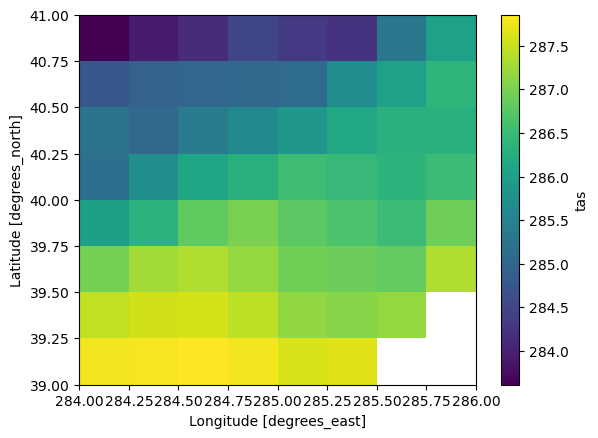

In [15]:
%%time
data_slice = observed.tas.sel(time="2010", lat=slice(39, 41), lon=slice(284, 286))
data_slice.mean(dim="time").compute().plot()

Compare that with the traditional method of opening the NetCDF files directly:

In [16]:
import fsspec

fs = fsspec.filesystem("s3", anon=True)

fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8 * 1024 * 1024,  # size in bytes per block, depends on the file size but recommendation is in the MBs
}

In [17]:
%%time
expected = xr.open_mfdataset(
    [fs.open(f"{s3_bucket}{path}" , **fsspec_caching) for path in all_files],
    engine="h5netcdf"
)
expected

CPU times: user 10.6 s, sys: 1.95 s, total: 12.5 s
Wall time: 1min 11s


<xarray.Dataset> Size: 82GB
Dimensions:  (time: 23725, lat: 600, lon: 1440)
Coordinates:
  * time     (time) object 190kB 1950-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tas      (time, lat, lon) float32 82GB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    downscalingModel:      BCSD
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    variant_label:         r1i1p1f2
    ...                    ...
    cmip6_institution_id:  NASA-GISS
    cmip6_license:         CC-BY-SA 4.0
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 21:42:29 PST 2024
    disclaimer:            These data are considered provisional and subject ...
    tracking_id:           ba64ebba-3c17-4348-b463-7e6ae7d11769

CPU times: user 7.81 s, sys: 127 ms, total: 7.94 s
Wall time: 8.46 s


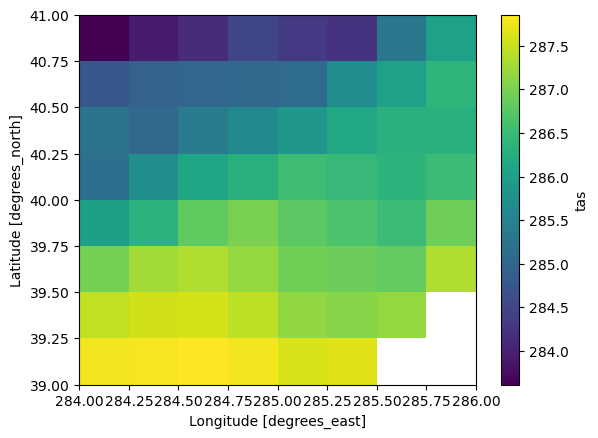

In [18]:
%%time
data_slice = expected.tas.sel(time="2010", lat=slice(39, 41), lon=slice(284, 286))
data_slice.mean(dim="time").compute().plot()